In [1]:
%matplotlib inline

In [2]:
import gridsim.grid_sim_linear_program as gslp
import gridsim.grid_sim_simple_example as gsse
import os.path as osp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Load profiles from California.  Profiles are for demand and non-dispatchable sources.

In [3]:
profiles_path = gsse.get_data_directory() + ['profiles', 'profiles_california.csv']
profiles_file = osp.join(*profiles_path)
profiles = pd.read_csv(profiles_file, index_col=0, parse_dates=True)
profiles.columns

Index([u'DEMAND', u'SOLAR', u'WIND', u'COAL', u'COAL_CRYO', u'COAL_AMINE',
       u'NUCLEAR'],
      dtype='object')

# Setup a Linear Program (LP) with DEMAND

In [4]:
lp = gslp.LinearProgramContainer(profiles)
lp.add_demands(gslp.GridDemand('DEMAND'))

In [5]:
# Simplest LP ever, add natural-gas source which is dispatchable so it can arbitrarily match demand
lp.add_dispatchable_sources(
      gslp.GridSource(
          name='NG',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=1239031,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=17.5,  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.33,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False))  # Not in Renewable Portfolio Standard.  

# Also adjust lp based upon what we think future costs are going to be.
hours_per_year = 24 * 365
annual_discount_rate = 0.06
lifetime_in_years = 30

lp.carbon_tax = 0 # No Carbon Tax
lp.rps_percent = 0 # No renewable requirement
lp.cost_of_money = gslp.extrapolate_cost(
  1.0,
  annual_discount_rate,
  lp.number_of_timeslices / hours_per_year,
  lifetime_in_years)

### Calling lp.solve() runs the linear program.  It returns True if the LP converged.

In [6]:
lp.solve()

True

### source_stats(lp) shows statistics about each source in the LP after the LP has converged.

In [7]:
def source_stats(lp):
    index = []
    capital = []
    variable = []
    co2_per_mwh = []
    nameplate = []
    generated = []
    
    for s in lp.sources:
        index.append(s.name)
        capital.append(s.nameplate_unit_cost)
        variable.append(s.variable_unit_cost)
        co2_per_mwh.append(s.co2_per_electrical_energy)
        nameplate.append(s.get_nameplate_solution_value())
        generated.append(sum(s.get_solution_values()))
        
    data = {'capital': capital,
           'variable': variable,
           'co2_per_mwh': co2_per_mwh,
           'nameplate': nameplate,
           'generated': generated}
    
    df = pd.DataFrame(index=index,
                      data=data)
    df['cost_of_money'] = lp.cost_of_money
    df['carbon_tax'] = lp.carbon_tax
    df['total_cost'] = (df.capital * df.nameplate +
                        df.cost_of_money * df.generated *
                        (df.variable + df.co2_per_mwh * df.carbon_tax))
    return df

In [8]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031,0.33,282784506.0,57747.0,17.5,14.590721,0,1.437558e+11


### plot_sources(lp) plots power / time of sources and demand.

In [9]:
def plot_labels(lp):
    plt.xlabel('Hour of Year')
    plt.ylabel('MegaWatts')
    
    title_string = 'Demand and Sources:'
    title_string += 'RPS = %d, Carbon Tax = %d' %(lp.rps_percent,
                                                 lp.carbon_tax)
    plt.title(title_string)
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    
def plot_sources(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    plt.plot(profiles.index[slicee], 
             profiles.DEMAND[slicee], label='Demand')
    for source in lp.sources:
        plt.plot(profiles.index[slicee],
                 source.get_solution_values()[slicee], label=source.name)
    plot_labels(lp)

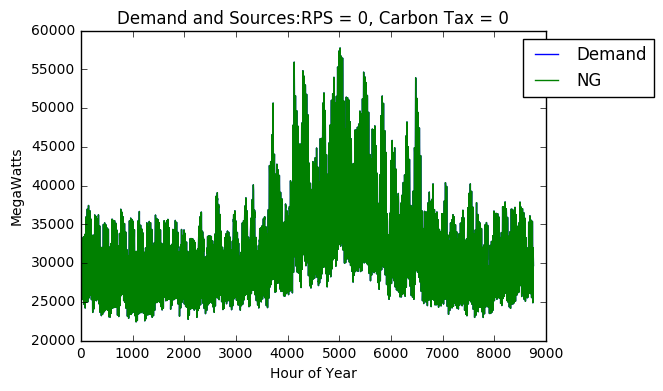

In [10]:
plot_sources(lp)

### Above run is not very interesting because there's only one source so it must match Demand identically

# Add Solar

In [11]:
solar = gslp.GridSource(
      name='SOLAR',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=946000,  # Aggressive solar cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 

lp.add_nondispatchable_sources(solar)     
lp.solve()

True

In [12]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031,0.33,282784506.0,57747.0,17.5,14.590721,0,1.437558e+11
SOLAR,946000,0.00,0.0,0.0,0.0,14.590721,0,0.000000e+00


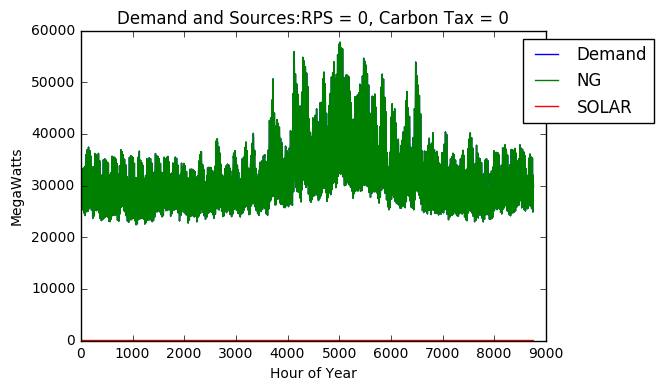

In [13]:
plot_sources(lp)


### Still only Natural Gas (NG) because NG is cheaper than Solar and he LP will generate the cheapest power subject to the constraints.

# Increase Renewable Portfolio Standard (RPS) % which mandates what % comes from renewables.

In [14]:
lp.rps_percent = 30
lp.solve()

True

In [15]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031,0.33,1.979492e+08,56008.572982,17.5,14.590721,0,1.199402e+11
SOLAR,946000,0.00,8.532477e+07,35353.403234,0.0,14.590721,0,3.344432e+10


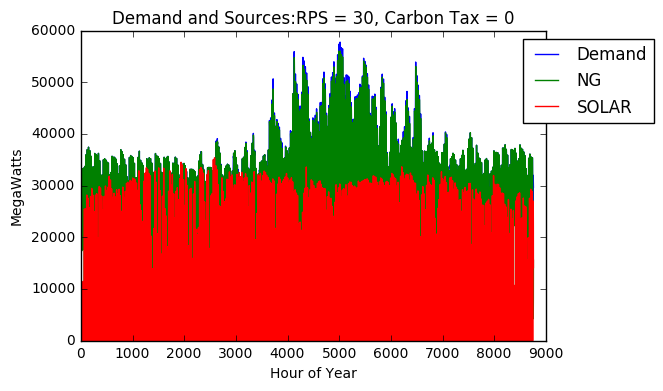

In [16]:
plot_sources(lp)

### Above is lots of data, and a little confusing, so let's slice it down somewhat.
### Here's 200 hours in the middle of the year. (Note hours are UTC)

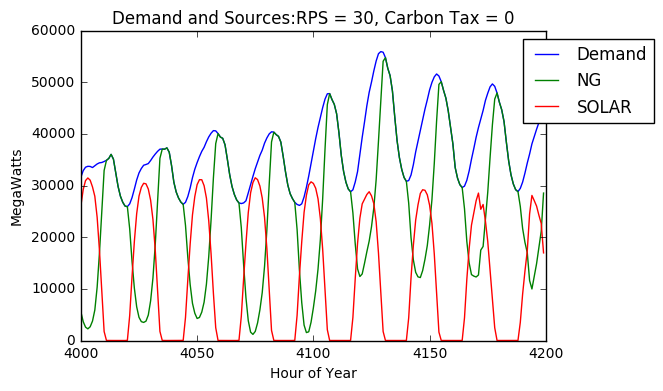

In [17]:
plot_sources(lp,slice(4000,4200))

# Add Wind to see how the LP handles Solar and Wind as RPS

In [18]:
wind = gslp.GridSource(
      name='WIND',  # Matches profile column name for nondispatch.                                                                                      
      nameplate_unit_cost=2051532,  # Aggressive wind cost $/MW                                                                                          
      variable_unit_cost=0,  # No fuel cost.                                                                                                             
      co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
      is_rps_source=True)  # In Renewable Portfolio Standard 
lp.add_nondispatchable_sources(wind)
     
lp.solve()

True

In [19]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031,0.33,1.979492e+08,56008.572982,17.5,14.590721,0,1.199402e+11
SOLAR,946000,0.00,8.532477e+07,35353.403234,0.0,14.590721,0,3.344432e+10
WIND,2051532,0.00,0.000000e+00,0.000000,0.0,14.590721,0,0.000000e+00


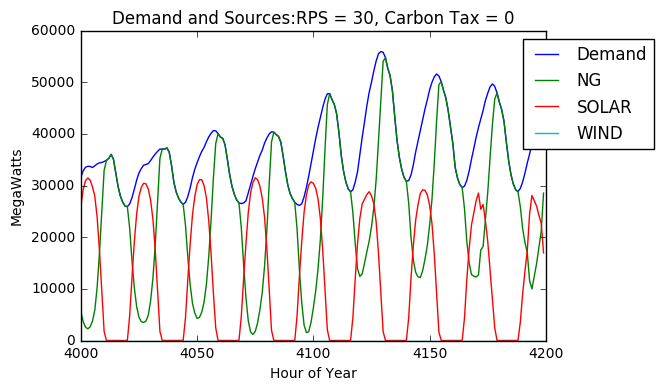

In [20]:
plot_sources(lp,slice(4000,4200))

### Solar is so much cheaper than wind (at a very futuristic price) so that no wind is used.

# Bring Solar Costs Back Somewhat to Present Day.

In [21]:
solar.nameplate_unit_cost = 1.5e6 # $ / Mw
lp.solve()

True

In [22]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031.0,0.33,1.979492e+08,52747.308272,17.5,14.590721,0,1.158994e+11
SOLAR,1500000.0,0.00,6.642535e+07,27522.632468,0.0,14.590721,0,4.128395e+10
WIND,2051532.0,0.00,1.843309e+07,6153.432086,0.0,14.590721,0,1.262396e+10


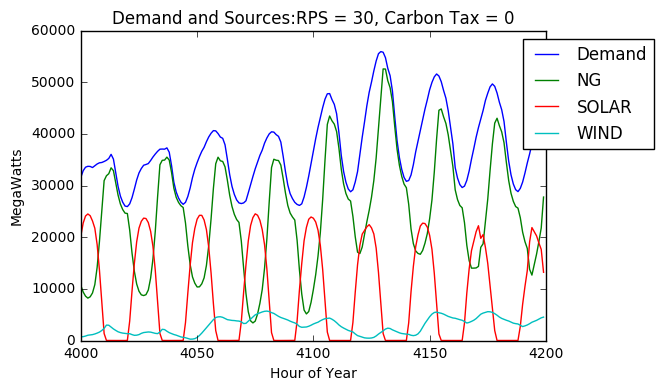

In [23]:
plot_sources(lp,slice(4000,4200))

### Some wind is now showing up.

# Increase rps_percent and Watch the Wind / Solar Distribution.

In [24]:
lp.rps_percent = 60
lp.solve()

True

In [25]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031.0,0.33,1.131138e+08,50512.978848,17.5,14.590721,0,9.146936e+10
SOLAR,1500000.0,0.00,6.052110e+07,25076.268225,0.0,14.590721,0,3.761440e+10
WIND,2051532.0,0.00,1.184480e+08,39540.954484,0.0,14.590721,0,8.111953e+10


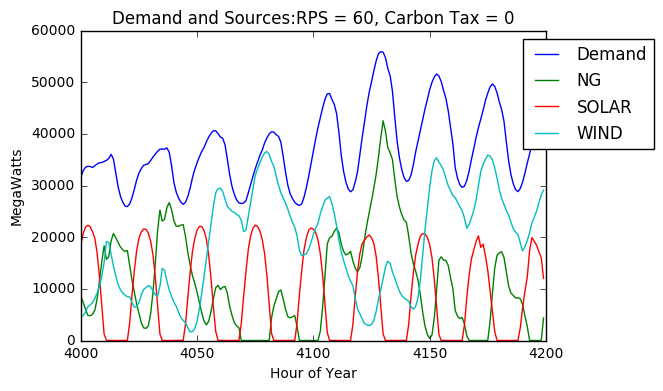

In [26]:
plot_sources(lp,slice(4000,4200))

### Solar Capacity slightly decreased 28GW -> 25GW 
### Wind Capacity surged 6GW -> 40GW

# Add Storage 

In [27]:
# Note: solving takes somewhat more time with storage
storage = gslp.GridRecStorage(
    name='STORAGE',
    storage_nameplate_cost=187000, # $ / Mwh of storage capacity
    charge_nameplate_cost=100000, # $ / Mw of charging capacity
    discharge_nameplate_cost=100000, # $ / Mw of discharging capacity
    charge_efficiency=0.9,
    discharge_efficiency=0.9,
    storage_efficiency=1.0)
lp.add_storage(storage)
lp.solve()

True

In [28]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031.0,0.33,1.136840e+08,37404.827915,17.5,14.590721,0,7.537354e+10
SOLAR,1500000.0,0.00,8.174076e+07,33868.406897,0.0,14.590721,0,5.080261e+10
WIND,2051532.0,0.00,9.288944e+07,31008.855604,0.0,14.590721,0,6.361566e+10


In [29]:
# Helper function to show cost and usage information for storage.

def storage_stats(lp):
    index = []
    capital_charge = []
    capital_discharge = []
    capital_storage = []
    storage_capacity = []
    charge_capacity = []
    discharge_capacity = []
    
    for s in lp.storage:
        index.append(s.name)
        capital_charge.append(s.charge_nameplate_cost)
        capital_discharge.append(s.discharge_nameplate_cost)
        capital_storage.append(s.storage_nameplate_cost)
        storage_capacity.append(s.energy_nameplate.solution_value())
        charge_capacity.append(s.charge_nameplate.solution_value())
        discharge_capacity.append(s.discharge_nameplate.solution_value())
    df = pd.DataFrame(index=index,
                     data={'capital_charge': capital_charge,
                           'capital_storage': capital_storage,
                           'capital_discharge': capital_discharge,
                           'storage_capacity': storage_capacity,
                           'charge_capacity': charge_capacity,
                           'discharge_capacity': discharge_capacity
                           })
    df['total_cost'] = (df.capital_storage * df.storage_capacity +
                        df.capital_charge * df.charge_capacity +
                        df.capital_discharge * df.discharge_capacity)
    return df

In [30]:
storage_stats(lp)

,capital_charge,capital_discharge,capital_storage,charge_capacity,discharge_capacity,storage_capacity,total_cost
STORAGE,100000,100000,187000,7787.211102,15053.412148,59774.684898,1.346193e+10


In [31]:
# Helper function to plot storage results.
# Negative numbers mean power from grid to storage.
# Positive numbers mean power from storage to grid.
def plot_storage(lp, slicee=None):
    if slicee is None:
        slicee = slice(lp.number_of_timeslices)
    profiles = lp.profiles
    for storage in lp.storage:
        name = storage.name
        charging_variables = (
            storage.rec_storage.sink.get_solution_values() + 
            storage.no_rec_storage.sink.get_solution_values())
        discharging_variables = (
            storage.rec_storage.source.get_solution_values() + 
            storage.no_rec_storage.source.get_solution_values())
        
        plt.plot(profiles.index[slicee],
                 discharging_variables[slicee]
                 -charging_variables[slicee], 
                 label='%s to grid' % name)
    plot_labels(lp)

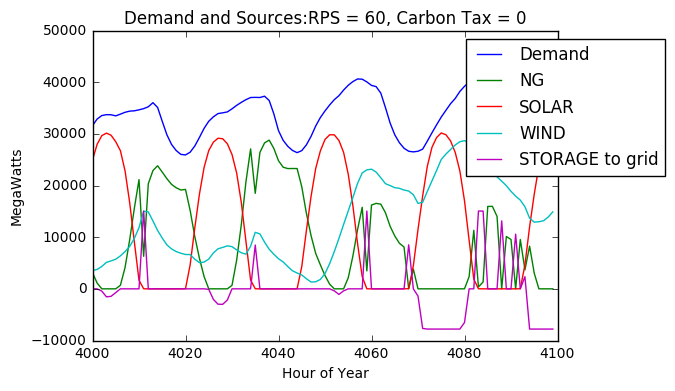

In [32]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)

### Negative Storage_to_grid means storage is charging from grid.
### Positive Storage_to_grid means storage is powering grid

# Increase rps_percent to 90%.
### Storage may be needed for extremely high rps_percentages.

In [33]:
lp.rps_percent = 90
lp.solve()

True

In [34]:
source_stats(lp)

,capital,co2_per_mwh,generated,nameplate,variable,cost_of_money,carbon_tax,total_cost
NG,1239031.0,0.33,2.947029e+07,19479.701808,17.5,14.590721,0,3.166083e+10
SOLAR,1500000.0,0.00,1.967364e+08,81515.617946,0.0,14.590721,0,1.222734e+11
WIND,2051532.0,0.00,1.076173e+08,35925.384685,0.0,14.590721,0,7.370208e+10


In [35]:
storage_stats(lp)

,capital_charge,capital_discharge,capital_storage,charge_capacity,discharge_capacity,storage_capacity,total_cost
STORAGE,100000,100000,187000,35098.192808,33748.656431,256009.393329,5.475844e+10


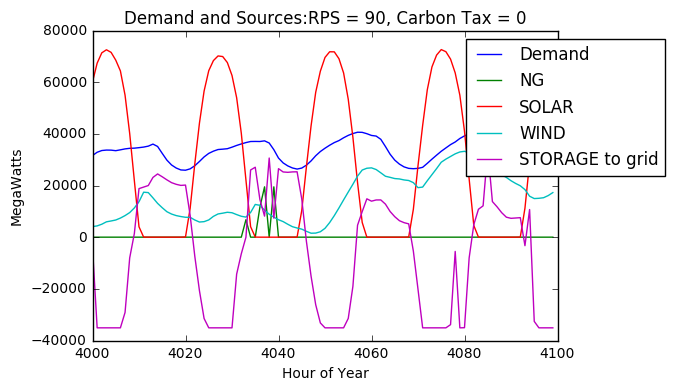

In [36]:
s = slice(4000,4100)
plot_sources(lp,s)
plot_storage(lp,s)